# American Footbal Big Data Insights

In this notebook we explore the data pro
vided on the kaggle competition "[NFL Big Data Bowl](https://www.kaggle.com/c/nfl-big-data-bowl-2020/data)".
The data describes 512 American Football games and definetely contains a lot of insights!
So, to start let's understand how to play American Football!

## The Rules

To understand the rules we advise you to watch [this video](https://www.youtube.com/watch?v=Ddwp1HyEFRE)

Full games you can find on [this channel](https://www.youtube.com/channel/UCP4Wts8iiR9-Ddfq7FK0x3g/videos)

Now, we are ready to take a look on the data!

## First look on the data

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
!ls data

train.csv  train.csv.zip


In [3]:
raw_data = pd.read_csv('data/train.csv')
raw_data.head()

/home/femoiseev/miniconda3/envs/ada/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509762 entries, 0 to 509761
Data columns (total 49 columns):
GameId                    509762 non-null int64
PlayId                    509762 non-null int64
Team                      509762 non-null object
X                         509762 non-null float64
Y                         509762 non-null float64
S                         509762 non-null float64
A                         509762 non-null float64
Dis                       509762 non-null float64
Orientation               509744 non-null float64
Dir                       509748 non-null float64
NflId                     509762 non-null int64
DisplayName               509762 non-null object
JerseyNumber              509762 non-null int64
Season                    509762 non-null int64
YardLine                  509762 non-null int64
Quarter                   509762 non-null int64
GameClock                 509762 non-null object
PossessionTeam            509762 non-null object
Down   

In [5]:
data = raw_data.copy()

As we see some features may be null and have object type. Some of them like PlayerCollegeName or HomeTeamAbbr are just strings with the same format, but some need special processing:

## String columns cleaning

**GameClock** is represented as strig in format hh:mm:ss and **PlayerBirthDate** in string with format mm/dd/yyyy.
In order to operate with it we will transform to the pd.datetime

In [6]:
data['GameClock'] = pd.to_datetime(raw_data['GameClock'], format='%H:%M:%S')
data['PlayerBirthDate'] = pd.to_datetime(raw_data['PlayerBirthDate'], format='%m/%d/%Y')
data[['GameClock', 'PlayerBirthDate']].head()

,GameClock,PlayerBirthDate
0,1900-01-01 14:14:00,1988-12-29
1,1900-01-01 14:14:00,1989-03-25
2,1900-01-01 14:14:00,1989-01-21
3,1900-01-01 14:14:00,1982-11-22
4,1900-01-01 14:14:00,1987-08-17


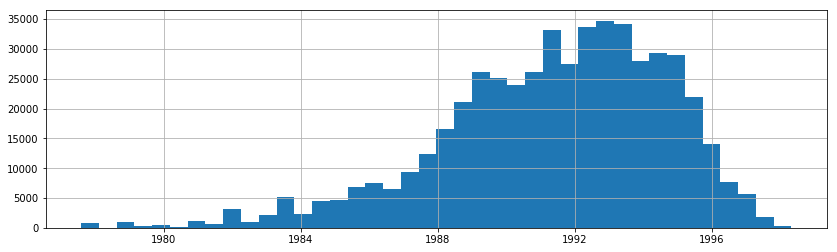

In [7]:
data['PlayerBirthDate'].hist(figsize=(14, 4), bins=40)
plt.show()

**PlayerHeight** is presented in one string with foots and inches in it. We will transform it to centimeters

In [8]:
raw_data[['PlayerHeight']].head()

,PlayerHeight
0,6-0
1,6-3
2,6-3
3,6-3
4,6-0


In [9]:
def ft_in_to_cm(string):
    foots, inches = string.split('-')
    foots, inches = int(foots), int(inches)
    return  30.48 * foots + 2.54 * inches

data['PlayerHeight'] = raw_data['PlayerHeight'].apply(ft_in_to_cm)
data[['PlayerHeight']].head()

,PlayerHeight
0,182.88
1,190.50
2,190.50
3,190.50
4,182.88


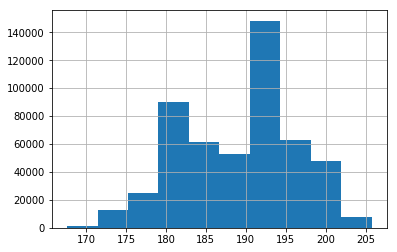

In [10]:
data['PlayerHeight'].hist()
plt.show()

**Stadium** is a string with name of stadium. As can we see from unique and sorted list of names there are some typos, which we will to correct 

In [11]:
stadiums = raw_data['Stadium'].unique()
stadiums.sort()
print(len(stadiums), stadiums)

55 ['AT&T Stadium' 'Arrowhead Stadium' 'Bank of America Stadium'
 'Broncos Stadium At Mile High' 'Broncos Stadium at Mile High'
 'CenturyField' 'CenturyLink' 'CenturyLink Field' 'Estadio Azteca'
 'EverBank Field' 'Everbank Field' 'FedExField' 'First Energy Stadium'
 'FirstEnergy' 'FirstEnergy Stadium' 'FirstEnergyStadium' 'Ford Field'
 'Gillette Stadium' 'Hard Rock Stadium' 'Heinz Field' 'Lambeau Field'
 'Lambeau field' 'Levis Stadium' 'Lincoln Financial Field'
 'Los Angeles Memorial Coliesum' 'Los Angeles Memorial Coliseum'
 'Lucas Oil Stadium' 'M & T Bank Stadium' 'M&T Bank Stadium' 'M&T Stadium'
 'Mercedes-Benz Dome' 'Mercedes-Benz Stadium' 'Mercedes-Benz Superdome'
 'MetLife' 'MetLife Stadium' 'Metlife Stadium' 'NRG' 'NRG Stadium'
 'New Era Field' 'Nissan Stadium' 'Oakland Alameda-County Coliseum'
 'Oakland-Alameda County Coliseum' 'Paul Brown Stadium'
 'Paul Brown Stdium' 'Raymond James Stadium' 'Soldier Field'
 'Sports Authority Field at Mile High' 'State Farm Stadium'
 'StubHub 

In [12]:
typos = {'Broncos Stadium At Mile High'   : 'Broncos Stadium at Mile High',
         'CenturyLink Field'              : 'CenturyLink',
         'Everbank Field'                 : 'EverBank Field',
         'FirstEnergyStadium'             : 'First Energy Stadium',
         'FirstEnergy'                    : 'First Energy Stadium',
         'FirstEnergy Stadium'            : 'First Energy Stadium',
         'Lambeau field'                  : 'Lambeau Field',
         'Los Angeles Memorial Coliesum'  : 'Los Angeles Memorial Coliseum',
         'M & T Bank Stadium'             : 'M&T Bank Stadium',
         'M&T Stadium'                    : 'M&T Bank Stadium',
         'MetLife'                        : 'MetLife Stadium',
         'Metlife Stadium'                : 'MetLife Stadium',
         'NRG'                            : 'NRG Stadium',
         'Oakland Alameda-County Coliseum': 'Oakland-Alameda County Coliseum',
         'Paul Brown Stdium'              : 'Paul Brown Stadium',
         'Twickenham'                     : 'Twickenham Stadium'
}

data['Stadium'] = raw_data['Stadium'].apply(lambda x: typos[x] if x in typos.keys() else x)
stadiums = data['Stadium'].unique()
stadiums.sort()
print(len(stadiums), stadiums)

39 ['AT&T Stadium' 'Arrowhead Stadium' 'Bank of America Stadium'
 'Broncos Stadium at Mile High' 'CenturyField' 'CenturyLink'
 'Estadio Azteca' 'EverBank Field' 'FedExField' 'First Energy Stadium'
 'Ford Field' 'Gillette Stadium' 'Hard Rock Stadium' 'Heinz Field'
 'Lambeau Field' 'Levis Stadium' 'Lincoln Financial Field'
 'Los Angeles Memorial Coliseum' 'Lucas Oil Stadium' 'M&T Bank Stadium'
 'Mercedes-Benz Dome' 'Mercedes-Benz Stadium' 'Mercedes-Benz Superdome'
 'MetLife Stadium' 'NRG Stadium' 'New Era Field' 'Nissan Stadium'
 'Oakland-Alameda County Coliseum' 'Paul Brown Stadium'
 'Raymond James Stadium' 'Soldier Field'
 'Sports Authority Field at Mile High' 'State Farm Stadium'
 'StubHub Center' 'TIAA Bank Field' 'Twickenham Stadium'
 'U.S. Bank Stadium' 'University of Phoenix Stadium' 'Wembley Stadium']


Google says that 'Mercedes-Benz Dome', 'Mercedes-Benz Stadium' and 'Mercedes-Benz Superdome' are 3 different stadiums.

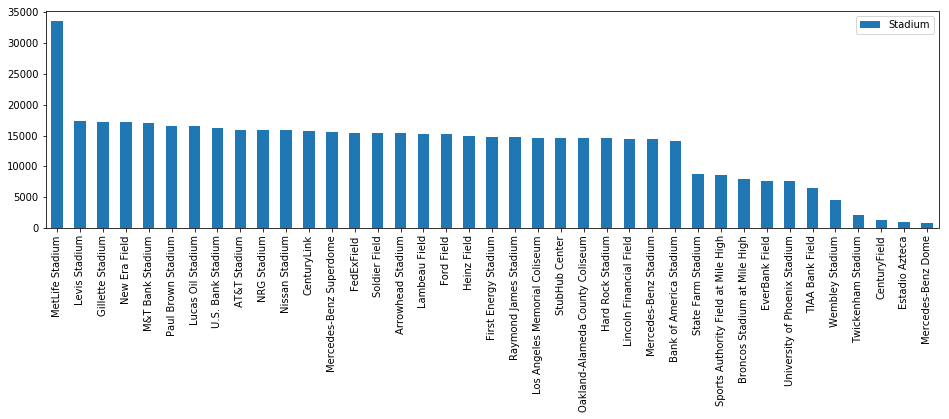

In [13]:
data[['Stadium']].apply(pd.value_counts).plot(kind='bar', figsize=(16, 4))
plt.show()

**StadiumType** – a string which again contains a lot of typos. 

'Heinz Field' and 'Cloudy' are not even a stadium type, so we will look for its value in other rows, as well as for nans

'Bowl' may be a type of stadion, but as we will see later it is seen only for one stadium together with other types, so we will also replace it with nan

In [14]:
stadium_type = data['StadiumType'].dropna().unique()
stadium_type.sort()
print(len(stadium_type), stadium_type)

29 ['Bowl' 'Closed Dome' 'Cloudy' 'Dome' 'Dome, closed' 'Domed' 'Domed, Open'
 'Domed, closed' 'Domed, open' 'Heinz Field' 'Indoor' 'Indoor, Open Roof'
 'Indoor, Roof Closed' 'Indoors' 'Open' 'Oudoor' 'Ourdoor' 'Outddors'
 'Outdoor' 'Outdoor Retr Roof-Open' 'Outdoors' 'Outdor' 'Outside'
 'Retr. Roof - Closed' 'Retr. Roof - Open' 'Retr. Roof Closed'
 'Retr. Roof-Closed' 'Retr. Roof-Open' 'Retractable Roof']


In [15]:
typos = {'Closed Dome'            : 'Dome-Closed',
         'Dome, closed'           : 'Dome-Closed',
         'Domed'                  : 'Dome',
         'Domed, closed'          : 'Dome-Closed',
         'Domed, open'            : 'Dome-Open',
         'Domed, Open'            : 'Dome-Open',
         'Indoors'                : 'Indoor',
         'Oudoor'                 : 'Outdoor',
         'Ourdoor'                : 'Outdoor',
         'Outddors'               : 'Outdoor',
         'Outdoors'               : 'Outdoor',
         'Outdor'                 : 'Outdoor',
         'Outside'                : 'Outdoor',
         'Retr. Roof Closed'      : 'Closed',
         'Retr. Roof-Closed'      : 'Closed',
         'Retr. Roof - Closed'    : 'Closed',
         'Retr. Roof - Open'      : 'Open',
         'Retr. Roof-Open'        : 'Open',
         'Outdoor Retr Roof-Open' : 'Open',
         'Indoor, Roof Closed'    : 'Indoor-Closed',
         'Indoor, Open Roof'      : 'Indoor-Open',
         'Heinz Field'            : np.nan,
         'Cloudy'                 : np.nan,
         'Bowl'                   : np.nan
}

data['StadiumType'] = raw_data['StadiumType'].apply(lambda x: typos[x] if x in typos.keys() else x)
stadium_type = data['StadiumType'].dropna().unique()
stadium_type.sort()
print(len(stadium_type), stadium_type)

10 ['Closed' 'Dome' 'Dome-Closed' 'Dome-Open' 'Indoor' 'Indoor-Closed'
 'Indoor-Open' 'Open' 'Outdoor' 'Retractable Roof']


In [16]:
data.groupby(by=['Stadium'])['StadiumType'].unique()

Stadium
AT&T Stadium                                                 [Indoor, Outdoor]
Arrowhead Stadium                                                    [Outdoor]
Bank of America Stadium                                              [Outdoor]
Broncos Stadium at Mile High                                         [Outdoor]
CenturyField                                                         [Outdoor]
CenturyLink                                                          [Outdoor]
Estadio Azteca                                                       [Outdoor]
EverBank Field                                                          [Open]
FedExField                                                           [Outdoor]
First Energy Stadium                                                 [Outdoor]
Ford Field                                                            [Indoor]
Gillette Stadium                                                     [Outdoor]
Hard Rock Stadium                           

Google says that StubHub Center is outdoor stadium, AT&T Stadium is indoor, for others we just substitude nans

In [17]:
data.loc[data['Stadium'] == 'StubHub Center', 'StadiumType'] = 'Outdoor'
data.loc[data['Stadium'] == 'AT&T Stadium', 'StadiumType'] = 'Indoor'
data.loc[data['Stadium'] == 'Heinz Field', 'StadiumType'] = 'Outdoor'
data.loc[data['Stadium'] == 'MetLife Stadium', 'StadiumType'] = 'Outdoor'
data.loc[data['Stadium'] == 'TIAA Bank Field', 'StadiumType'] = 'Outdoor' # TODO there is a second value

In [18]:
data.groupby(by=['Stadium'])['StadiumType'].unique()

Stadium
AT&T Stadium                                                          [Indoor]
Arrowhead Stadium                                                    [Outdoor]
Bank of America Stadium                                              [Outdoor]
Broncos Stadium at Mile High                                         [Outdoor]
CenturyField                                                         [Outdoor]
CenturyLink                                                          [Outdoor]
Estadio Azteca                                                       [Outdoor]
EverBank Field                                                          [Open]
FedExField                                                           [Outdoor]
First Energy Stadium                                                 [Outdoor]
Ford Field                                                            [Indoor]
Gillette Stadium                                                     [Outdoor]
Hard Rock Stadium                           

That is much better!

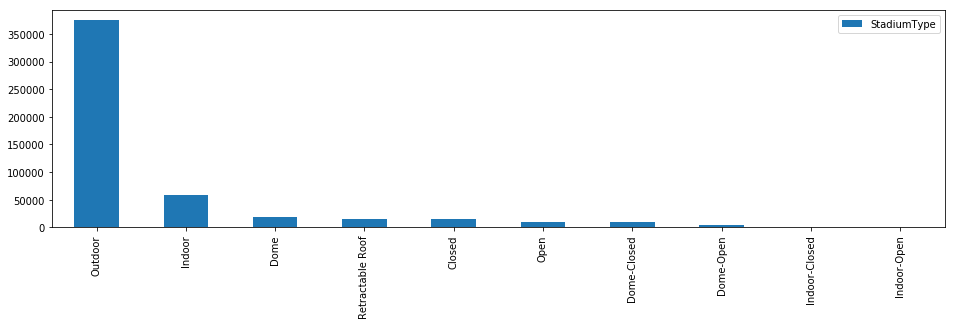

In [19]:
data[['StadiumType']].apply(pd.value_counts).plot(kind='bar', figsize=(16, 4))
plt.show()

TODO: Separate on several variables - indoor/outdoor/dome + open/closed, Where is retractable?

TODO: Is it any differenve between Dome and outdoor? 

**Turf** - again typos

In [20]:
turf = data['Turf'].dropna().unique()
turf.sort()
print(len(turf), turf)

20 ['A-Turf Titan' 'Artifical' 'Artificial' 'DD GrassMaster' 'Field Turf'
 'Field turf' 'FieldTurf' 'FieldTurf 360' 'FieldTurf360' 'Grass' 'Natural'
 'Natural Grass' 'Natural grass' 'Naturall Grass' 'SISGrass'
 'Twenty-Four/Seven Turf' 'UBU Speed Series-S5-M' 'UBU Sports Speed S5-M'
 'grass' 'natural grass']


In [21]:
typos = {'Natural grass'         : 'Natural Grass',
         'Naturall Grass'        : 'Natural Grass',
         'natural grass'         : 'Natural Grass',
         'Artifical'             : 'Artificial',
         'grass'                 : 'Grass',
         'Natural'               : 'Natural Grass',
         'FieldTurf360'          : 'FieldTurf 360',
         'Field turf'            : 'Field Turf',
         'FieldTurf'             : 'Field Turf',
         'UBU Speed Series-S5-M' : 'UBU Sports Speed S5-M'
}

data['Turf'] = raw_data['Turf'].apply(lambda x: typos[x] if x in typos.keys() else x)
turf = data['Turf'].dropna().unique()
turf.sort()
print(len(turf), turf)

10 ['A-Turf Titan' 'Artificial' 'DD GrassMaster' 'Field Turf' 'FieldTurf 360'
 'Grass' 'Natural Grass' 'SISGrass' 'Twenty-Four/Seven Turf'
 'UBU Sports Speed S5-M']


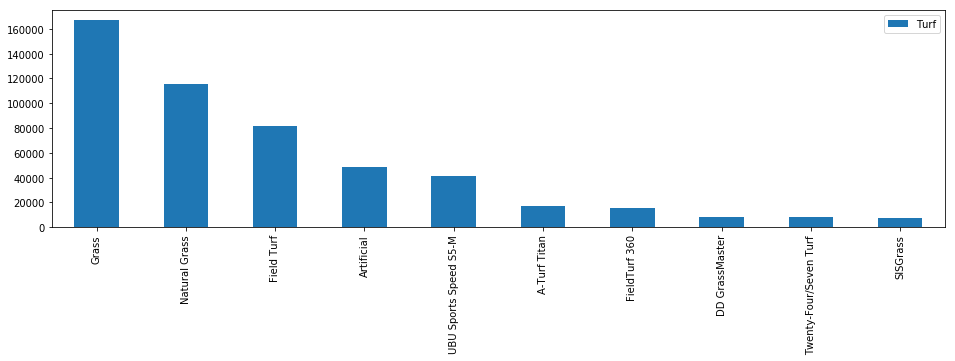

In [22]:
data[['Turf']].apply(pd.value_counts).plot(kind='bar', figsize=(16, 4))
plt.show()

**WindDirection**

In [23]:
wind = raw_data['WindDirection'].dropna().unique()
wind.sort()
print(len(wind), wind)

53 ['1' '13' '8' 'Calm' 'E' 'EAST' 'ENE' 'ESE' 'East' 'East North East'
 'East Southeast' 'From ESE' 'From NNE' 'From NNW' 'From S' 'From SSE'
 'From SSW' 'From SW' 'From W' 'From WSW' 'N' 'N-NE' 'NE' 'NNE' 'NNW' 'NW'
 'North' 'North East' 'North/Northwest' 'NorthEast' 'Northeast'
 'Northwest' 'S' 'SE' 'SSE' 'SSW' 'SW' 'South' 'South Southeast'
 'South Southwest' 'SouthWest' 'Southeast' 'Southwest' 'W' 'W-NW' 'W-SW'
 'WNW' 'WSW' 'West' 'West Northwest' 'West-Southwest' 'from W' 's']


The data is super dirty. At first we will get rid of 'From' suffix and '-' between cardinal directions

In [24]:
data['WindDirection'] = raw_data['WindDirection'].str.upper()\
                                                 .str.replace(' ', '')\
                                                 .str.replace('FROM', '')\
                                                 .str.replace('-', '')

wind = data['WindDirection'].dropna().unique()
wind.sort()
print(len(wind), wind)

35 ['1' '13' '8' 'CALM' 'E' 'EAST' 'EASTNORTHEAST' 'EASTSOUTHEAST' 'ENE'
 'ESE' 'N' 'NE' 'NNE' 'NNW' 'NORTH' 'NORTH/NORTHWEST' 'NORTHEAST'
 'NORTHWEST' 'NW' 'S' 'SE' 'SOUTH' 'SOUTHEAST' 'SOUTHSOUTHEAST'
 'SOUTHSOUTHWEST' 'SOUTHWEST' 'SSE' 'SSW' 'SW' 'W' 'WEST' 'WESTNORTHWEST'
 'WESTSOUTHWEST' 'WNW' 'WSW']


Next we will unify all directions

In [25]:
to_replace = {
              'NORTH/NORTHWEST'   : 'NNW',
              'SOUTHEAST'         : 'SE',
              'SOUTHWEST'         : 'SW',
              'NORTHEAST'         : 'NE',
              'NORTHWEST'         : 'NW',
              'EAST'              : 'E',
              'NORTH'             : 'N',
              'SOUTH'             : 'S',
              'WEST'              : 'W'
}

for word in to_replace.keys():
    data['WindDirection'] = data['WindDirection'].str.replace(word, to_replace[word])

wind = data['WindDirection'].dropna().unique()
wind.sort()
print(len(wind), wind)

20 ['1' '13' '8' 'CALM' 'E' 'ENE' 'ESE' 'N' 'NE' 'NNE' 'NNW' 'NW' 'S' 'SE'
 'SSE' 'SSW' 'SW' 'W' 'WNW' 'WSW']


And finally we will substitute numbers with nones as it is obviously a mistake

In [26]:
to_replace = {'1'   : np.nan,
              '13'  : np.nan,
              '8'   : np.nan
}

data['WindDirection'] = data['WindDirection'].apply(lambda x: to_replace[x] if x in to_replace.keys() else x)

wind = data['WindDirection'].dropna().unique()
wind.sort()
print(len(wind), wind)

17 ['CALM' 'E' 'ENE' 'ESE' 'N' 'NE' 'NNE' 'NNW' 'NW' 'S' 'SE' 'SSE' 'SSW'
 'SW' 'W' 'WNW' 'WSW']


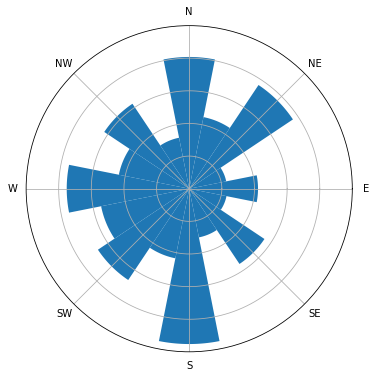

In [27]:
plt.figure(figsize=(6, 6))
directions = data[data['WindDirection'] != 'CALM']['WindDirection'].dropna().value_counts()
directions = directions.reindex(index=['E', 'ENE', 'NE', 'NNE', 
                                       'N', 'NNW', 'NW', 'WNW', 
                                       'W', 'WSW', 'SW', 'SSW', 
                                       'S', 'SSE', 'SE', 'ESE'])

theta = np.linspace(0.0, 2 * np.pi, len(directions), endpoint=False)
ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, directions.values, width = (2*np.pi) / len(directions))
ax.set_xticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'])
ax.set_yticklabels([])

plt.show()

**WindSpeed**

In [28]:
windSpeed = raw_data['WindSpeed'].dropna().unique()
print(len(windSpeed), windSpeed)

58 [8.0 6.0 10.0 9.0 11.0 7.0 5.0 2.0 12.0 1 3 4 13 '10' '5' '6' '4' '8' '0'
 'SSW' 14.0 0.0 15.0 17.0 18.0 16.0 '11-17' '16' '14' '13' '12' '23' '7'
 '9' '3' '17' '14-23' '1' '13 MPH' 24.0 '15' '12-22' '2' '4 MPh'
 '15 gusts up to 25' '11' '10MPH' '10mph' '22' 'E' '7 MPH' 'Calm' '6 mph'
 '19' 'SE' '20' '10-20' '12mph']


The data is very ununiform =( Some of the values are floats, some integers, some strings and some are even intervals. Ok, let's clear it

In [29]:
def process_raw_speed(speed):
    # try to simply convert to int
    try:
        return float(speed)
    except ValueError:
        pass

    if isinstance(speed, str): 
        numbers = [int(s) for s in re.findall(r'[0-9]+', speed)]
        if len(numbers) == 0:
            return np.nan

        # we will sumstitude intervals with its mean
        return np.mean(numbers)
    
    return speed
    
data['WindSpeed'] = raw_data['WindSpeed'].apply(process_raw_speed)

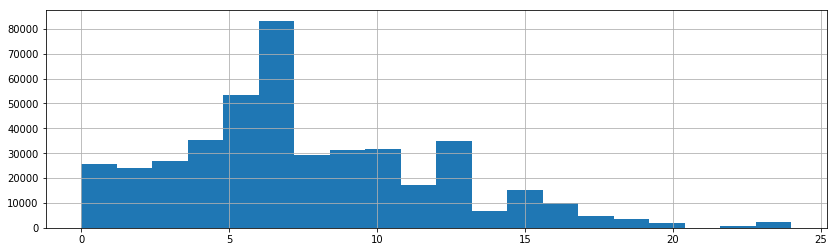

In [30]:
data['WindSpeed'].hist(figsize=(14, 4), bins=20)
plt.show()

**GameWeather** is the most difficult column for processing

In [31]:
weather = data['GameWeather'].str.lower().dropna().unique()
weather.sort()
print(len(weather), weather)

54 ['30% chance of rain' 'clear' 'clear and cold' 'clear and cool'
 'clear and sunny' 'clear and warm' 'clear skies' 'cloudy'
 'cloudy and cold' 'cloudy and cool'
 'cloudy with periods of rain, thunder possible. winds shifting to wnw, 10-20 mph.'
 'cloudy, 50% change of rain' 'cloudy, chance of rain'
 'cloudy, fog started developing in 2nd quarter'
 'cloudy, light snow accumulating 1-3"' 'cloudy, rain' 'cold'
 'controlled climate' 'coudy' 'fair' 'hazy' 'heavy lake effect snow'
 'indoor' 'indoors' 'light rain' 'mostly cloudy' 'mostly coudy'
 'mostly sunny' 'mostly sunny skies' 'n/a (indoors)' 'n/a indoor'
 'overcast' 'partly clear' 'partly cloudy' 'partly clouidy' 'partly sunny'
 'party cloudy' 'rain' 'rain chance 40%' 'rain likely, temps in low 40s.'
 'rain shower' 'rainy' 'scattered showers' 'showers' 'snow' 'sun & clouds'
 'sunny' 'sunny and clear' 'sunny and cold' 'sunny and warm' 'sunny skies'
 'sunny, highs to upper 80s' 'sunny, windy' 't: 51; h: 55; w: nw 10 mph']


TODO: decide what to do with it, may be NLP

### OffensePersonnel / DefensePersonnel

In [52]:
offense = raw_data['OffensePersonnel'].dropna().unique()
offense.sort()
print(len(offense), offense)

56 ['0 RB, 0 TE, 5 WR' '0 RB, 1 TE, 4 WR' '0 RB, 2 TE, 3 WR'
 '0 RB, 3 TE, 2 WR' '1 RB, 0 TE, 3 WR,1 DB' '1 RB, 0 TE, 4 WR'
 '1 RB, 1 TE, 2 WR,1 DB' '1 RB, 1 TE, 2 WR,1 DL' '1 RB, 1 TE, 2 WR,1 LB'
 '1 RB, 1 TE, 3 WR' '1 RB, 2 TE, 1 WR,1 DB' '1 RB, 2 TE, 1 WR,1 DL'
 '1 RB, 2 TE, 1 WR,1 LB' '1 RB, 2 TE, 2 WR' '1 RB, 2 TE, 3 WR'
 '1 RB, 3 TE, 0 WR,1 DB' '1 RB, 3 TE, 0 WR,1 DL' '1 RB, 3 TE, 0 WR,1 LB'
 '1 RB, 3 TE, 1 WR' '1 RB, 4 TE, 0 WR' '2 QB, 1 RB, 0 TE, 3 WR'
 '2 QB, 1 RB, 1 TE, 2 WR' '2 QB, 1 RB, 2 TE, 1 WR'
 '2 QB, 1 RB, 3 TE, 0 WR' '2 QB, 2 RB, 0 TE, 2 WR'
 '2 QB, 2 RB, 1 TE, 1 WR' '2 QB, 2 RB, 2 TE, 0 WR'
 '2 QB, 3 RB, 1 TE, 0 WR' '2 RB, 0 TE, 3 WR' '2 RB, 1 TE, 1 WR,1 DB'
 '2 RB, 1 TE, 2 WR' '2 RB, 2 TE, 0 WR,1 DL' '2 RB, 2 TE, 1 WR'
 '2 RB, 3 TE, 0 WR' '2 RB, 3 TE, 1 WR' '3 RB, 0 TE, 2 WR'
 '3 RB, 1 TE, 1 WR' '3 RB, 2 TE, 0 WR' '6 OL, 0 RB, 2 TE, 2 WR'
 '6 OL, 1 RB, 0 TE, 3 WR' '6 OL, 1 RB, 1 TE, 0 WR,2 DL'
 '6 OL, 1 RB, 1 TE, 1 WR,1 DL' '6 OL, 1 RB, 1 TE, 2 WR'
 '6 OL, 1 RB, 2 

In [33]:
defense = raw_data['DefensePersonnel'].dropna().unique()
defense.sort()
print(len(defense), defense)

38 ['0 DL, 4 LB, 7 DB' '0 DL, 5 LB, 6 DB' '0 DL, 6 LB, 5 DB'
 '1 DL, 2 LB, 8 DB' '1 DL, 3 LB, 7 DB' '1 DL, 4 LB, 6 DB'
 '1 DL, 5 LB, 5 DB' '2 DL, 2 LB, 7 DB' '2 DL, 3 LB, 6 DB'
 '2 DL, 4 LB, 4 DB, 1 OL' '2 DL, 4 LB, 5 DB' '2 DL, 5 LB, 4 DB'
 '3 DL, 1 LB, 7 DB' '3 DL, 2 LB, 6 DB' '3 DL, 3 LB, 5 DB'
 '3 DL, 4 LB, 3 DB, 1 OL' '3 DL, 4 LB, 4 DB' '3 DL, 5 LB, 3 DB'
 '4 DL, 0 LB, 7 DB' '4 DL, 1 LB, 6 DB' '4 DL, 2 LB, 5 DB'
 '4 DL, 3 LB, 4 DB' '4 DL, 4 LB, 3 DB' '4 DL, 5 LB, 1 DB, 1 OL'
 '4 DL, 5 LB, 2 DB' '4 DL, 6 LB, 1 DB' '5 DL, 1 LB, 5 DB'
 '5 DL, 2 LB, 4 DB' '5 DL, 3 LB, 2 DB, 1 OL' '5 DL, 3 LB, 3 DB'
 '5 DL, 4 LB, 1 DB, 1 OL' '5 DL, 4 LB, 2 DB' '5 DL, 5 LB, 1 DB'
 '6 DL, 1 LB, 4 DB' '6 DL, 2 LB, 3 DB' '6 DL, 3 LB, 2 DB'
 '6 DL, 4 LB, 1 DB' '7 DL, 2 LB, 2 DB']


DefensePersonnel and OffensePersonnel describes team positional grouping. They are not noisy, so we will not change them for now. But let's create numeric features from them: parse each string "x DL, y LB, ..." to column DL with value x, column LB with value y etc.

In [67]:
offense_positions = np.unique([x.strip()[-2:] for line in offense for x in line.split(',')])
defense_positions = np.unique([x.strip()[-2:] for line in defense for x in line.split(',')])
print(offense_positions)
print(defense_positions)

['DB' 'DL' 'LB' 'OL' 'QB' 'RB' 'TE' 'WR']
['DB' 'DL' 'LB' 'OL']


In [81]:
def parse_positions(series, column_names, prefix=''):
    column_names = list(column_names)
    res = np.zeros((len(series), len(column_names)), dtype=np.int)
    for i, row in series.iteritems():
        for pos in row.split(','):
            pos = pos.strip()
            val = int(pos[:-3])
            ind = column_names.index(pos[-2:])
            res[i, ind] = val
            
    return pd.DataFrame(data=res, index=series.index, columns=[prefix + name for name in column_names])

In [82]:
offense_parsed = parse_positions(data['OffensePersonnel'], offense_positions, prefix='offense_')
defense_parsed = parse_positions(data['DefensePersonnel'], defense_positions, prefix='defense_')

In [85]:
data = data.merge(offense_parsed, left_index=True, right_index=True)\
           .merge(defense_parsed, left_index=True, right_index=True)
data.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,offense_LB,offense_OL,offense_QB,offense_RB,offense_TE,offense_WR,defense_DB,defense_DL,defense_LB,defense_OL
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,0,0,0,1,1,3,6,2,3,0
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,0,0,0,1,1,3,6,2,3,0
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,0,0,0,1,1,3,6,2,3,0
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,0,0,0,1,1,3,6,2,3,0
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,0,0,0,1,1,3,6,2,3,0


### TimeHandoff, TimeSnap

Parse it to the datetime

In [86]:
time_handoff = raw_data['TimeHandoff'].dropna().unique()
time_handoff.sort()
print(len(time_handoff), time_handoff)

22935 ['2017-09-08T00:44:06.000Z' '2017-09-08T00:44:27.000Z'
 '2017-09-08T00:45:17.000Z' ... '2018-12-31T04:01:05.000Z'
 '2018-12-31T04:01:45.000Z' '2018-12-31T04:18:19.000Z']


In [87]:
time_snap = raw_data['TimeSnap'].dropna().unique()
time_snap.sort()
print(len(time_snap), time_snap)

22943 ['2017-09-08T00:44:05.000Z' '2017-09-08T00:44:26.000Z'
 '2017-09-08T00:45:15.000Z' ... '2018-12-31T04:01:04.000Z'
 '2018-12-31T04:01:44.000Z' '2018-12-31T04:18:18.000Z']


TimeHandoff and TimeSnap are just datetime, so let's parse it.

In [88]:
data['TimeHandoff'] = raw_data['TimeHandoff'].apply(pd.to_datetime)
data['TimeSnap'] = raw_data['TimeSnap'].apply(pd.to_datetime)

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509762 entries, 0 to 509761
Data columns (total 61 columns):
GameId                    509762 non-null int64
PlayId                    509762 non-null int64
Team                      509762 non-null object
X                         509762 non-null float64
Y                         509762 non-null float64
S                         509762 non-null float64
A                         509762 non-null float64
Dis                       509762 non-null float64
Orientation               509744 non-null float64
Dir                       509748 non-null float64
NflId                     509762 non-null int64
DisplayName               509762 non-null object
JerseyNumber              509762 non-null int64
Season                    509762 non-null int64
YardLine                  509762 non-null int64
Quarter                   509762 non-null int64
GameClock                 509762 non-null datetime64[ns]
PossessionTeam            509762 non-null object

# Initial data exploration

### Histograms

Firstly, let's look to the histogram of each numeric feature.

In [90]:
data_numeric = data.select_dtypes(include=[np.number])
data_numeric.head()

,GameId,PlayId,X,Y,S,A,Dis,Orientation,Dir,NflId,...,offense_LB,offense_OL,offense_QB,offense_RB,offense_TE,offense_WR,defense_DB,defense_DL,defense_LB,defense_OL
0,2017090700,20170907000118,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,...,0,0,0,1,1,3,6,2,3,0
1,2017090700,20170907000118,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,...,0,0,0,1,1,3,6,2,3,0
2,2017090700,20170907000118,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,...,0,0,0,1,1,3,6,2,3,0
3,2017090700,20170907000118,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,...,0,0,0,1,1,3,6,2,3,0
4,2017090700,20170907000118,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,...,0,0,0,1,1,3,6,2,3,0


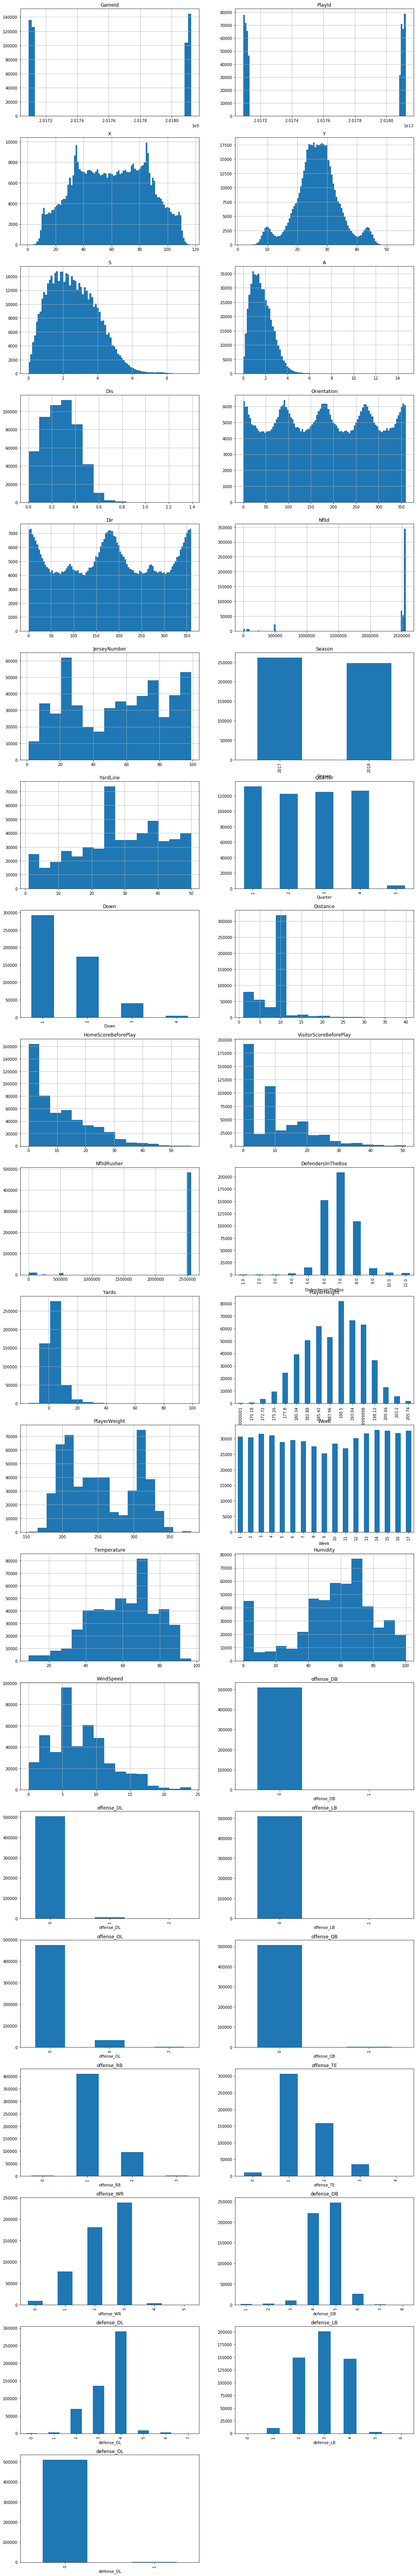

In [105]:
n_columns = 2
n_rows = (data_numeric.shape[1] - 1) // n_columns + 1

plt.figure(figsize=(n_columns * 9, n_rows * 6))

for i, column in enumerate(data_numeric.columns):
    plt.subplot(n_rows, n_columns, i+1)
    
    if len(data_numeric[column].unique()) < 20:
        data_numeric.groupby(column)[column].count().plot.bar()
    else:
        data_numeric[column].hist(bins=min(100, max(15, len(data_numeric[column].unique()) // 10)))
    plt.title(column)
    
plt.show()

Interesting columns: X, Y (unobvious patterns), Orientation, Dir (interesting shape of histogram, cycle structure, few peaks), PlayerWeight, JerseyNumber (few peaks).

Let's also look to the distribution of average feature value for player.

In [96]:
data_player = data_numeric.groupby(by='NflId').aggregate('mean')
data_player_numeric = data_player.select_dtypes(include=[np.number])

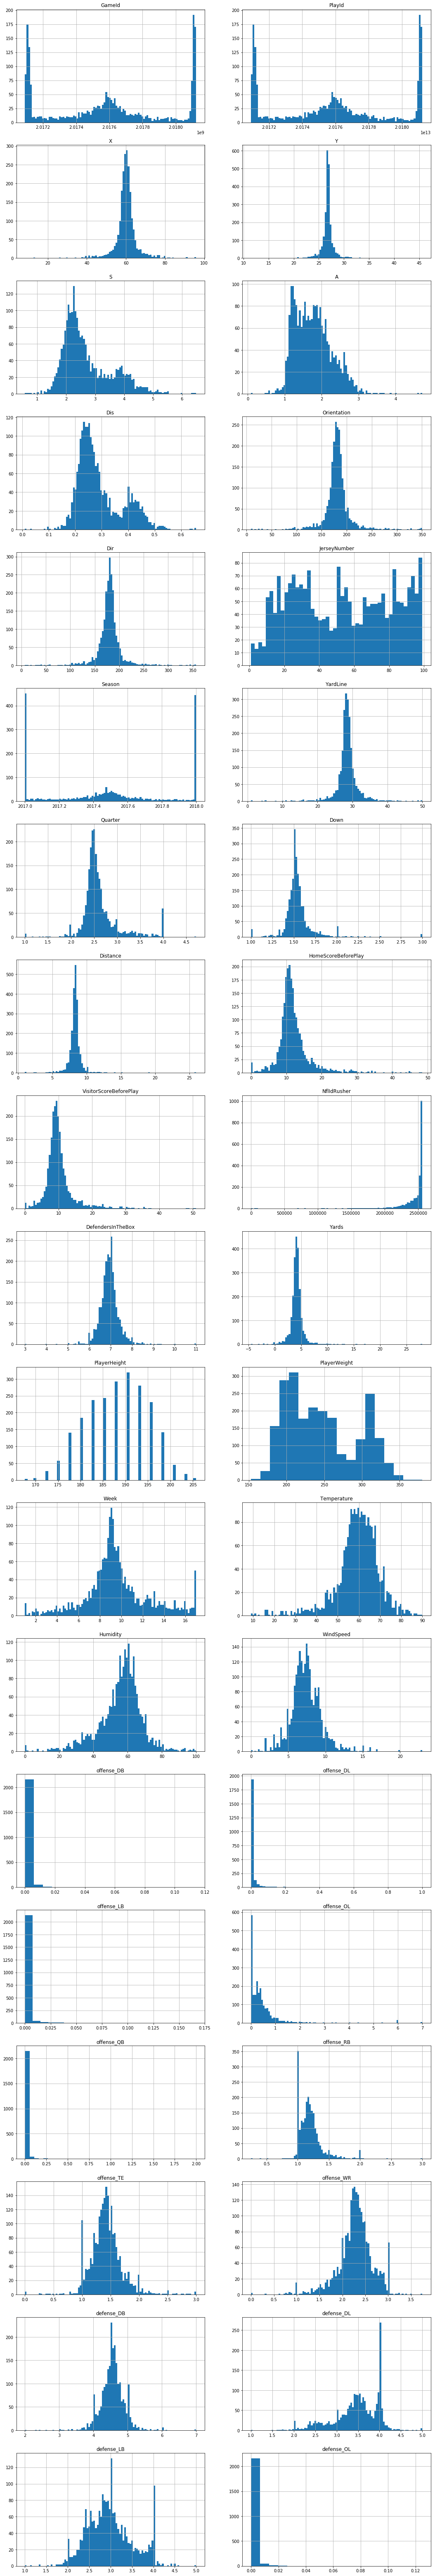

In [97]:
n_columns = 2
n_rows = (data_numeric.shape[1] - 1) // n_columns + 1

plt.figure(figsize=(n_columns * 9, n_rows * 6))

for i, column in enumerate(data_player_numeric.columns):
    plt.subplot(n_rows, n_columns, i+1)
    data_player_numeric[column].hist(bins=min(100, max(15, len(data_player_numeric[column].unique()) // 10)))
    plt.title(column)
    
plt.show()

Additional interesting notes: two peaks in Dis and Speed.

### Correlation

Then let's compute correlation coefficient between every pair of features. 

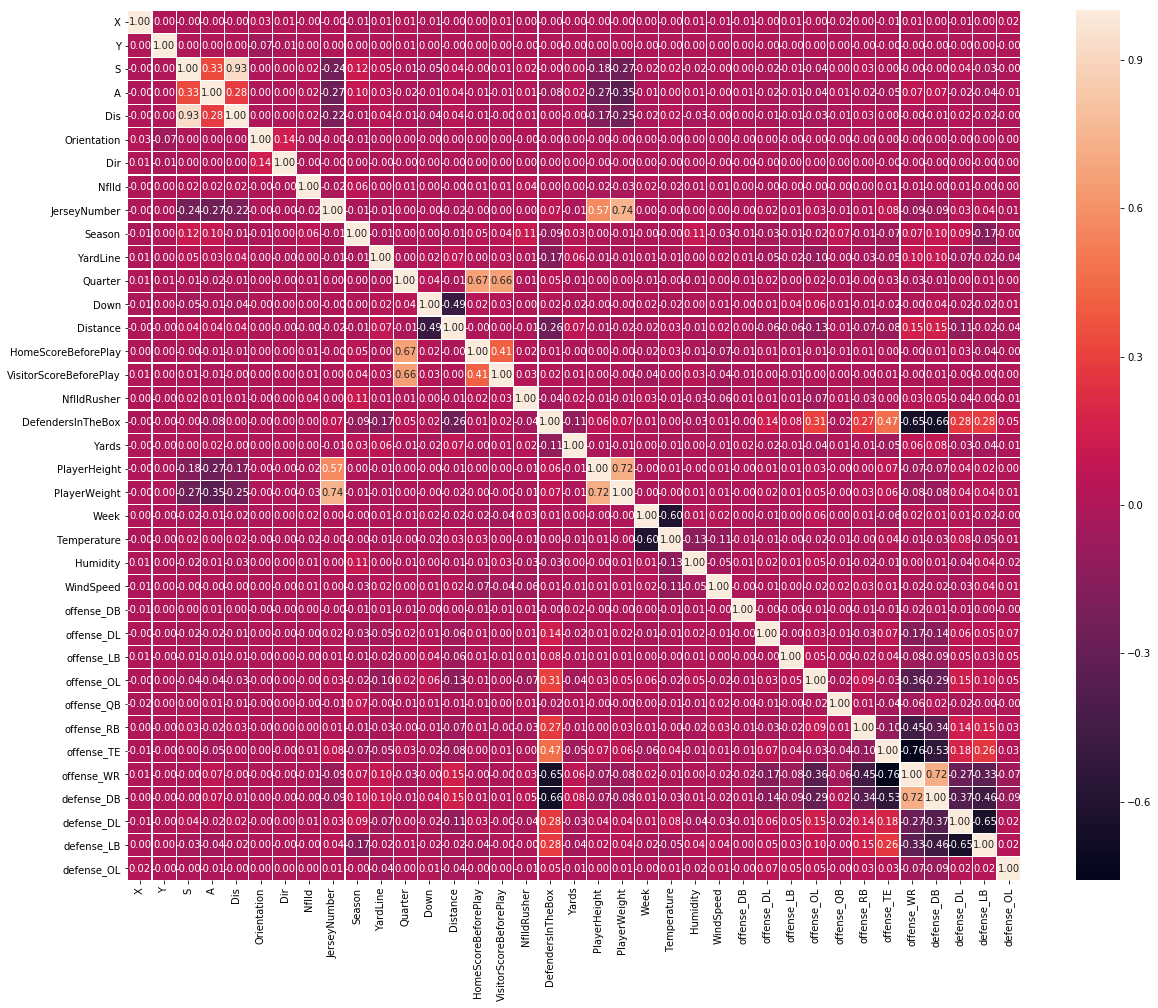

In [98]:
plt.figure(figsize=(20, 16))
sns.heatmap(data.iloc[:,2:].corr(),annot=True, linewidths=.1, fmt='.2f')

plt.show()

Relatively strong correlations: Distance-Down, PlayerWeight-A (heavy players are slow, ha-ha), Temperature-Week (very logical too), PlayerHeight-PlayerWeight, PlayerHeight/Weight-JerseyNumber (it can be interesting to understand NFL jersey numbering system) and few others. Unfortunately, there are no strong linear correlation with Yards (target variable).

# First trained model

In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509762 entries, 0 to 509761
Data columns (total 61 columns):
GameId                    509762 non-null int64
PlayId                    509762 non-null int64
Team                      509762 non-null object
X                         509762 non-null float64
Y                         509762 non-null float64
S                         509762 non-null float64
A                         509762 non-null float64
Dis                       509762 non-null float64
Orientation               509744 non-null float64
Dir                       509748 non-null float64
NflId                     509762 non-null int64
DisplayName               509762 non-null object
JerseyNumber              509762 non-null int64
Season                    509762 non-null int64
YardLine                  509762 non-null int64
Quarter                   509762 non-null int64
GameClock                 509762 non-null datetime64[ns]
PossessionTeam            509762 non-null object

Let's train Catboost model (gradient boosting on trees) on meaningful features. We chose catboost because it can handle categorical features well.

In [109]:
from catboost import CatBoostRegressor

In [171]:
import math

bad_features = ['GameId', 'PlayId', 'Season']
good_features = [column for column in data.columns if column not in bad_features]
target = 'Yards'

X = data[good_features].drop('Yards', axis=1)
y = data['Yards']

datetime_features = [column for column, dtype in zip(X.columns, X.dtypes) if str(dtype).startswith('datetime64')]

X = X.drop(datetime_features, axis=1)  # For now

categorical_features = [column for column, dtype in zip(X.columns, X.dtypes) if dtype == 'object']
X.loc[:, categorical_features] = X[categorical_features].fillna('NaN')

In [172]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [173]:
model = CatBoostRegressor()
model.fit(X_train, y_train, cat_features=categorical_features, eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 6.4340480	test: 6.3980060	best: 6.3980060 (0)	total: 483ms	remaining: 8m 2s
1:	learn: 6.4241685	test: 6.3879436	best: 6.3879436 (1)	total: 1.03s	remaining: 8m 32s
2:	learn: 6.4179601	test: 6.3815763	best: 6.3815763 (2)	total: 1.48s	remaining: 8m 12s
3:	learn: 6.4075980	test: 6.3707376	best: 6.3707376 (3)	total: 1.92s	remaining: 7m 56s
4:	learn: 6.4019702	test: 6.3649226	best: 6.3649226 (4)	total: 2.26s	remaining: 7m 29s
5:	learn: 6.3922510	test: 6.3548872	best: 6.3548872 (5)	total: 2.6s	remaining: 7m 11s
6:	learn: 6.3834087	test: 6.3455989	best: 6.3455989 (6)	total: 2.97s	remaining: 7m
7:	learn: 6.3762225	test: 6.3380368	best: 6.3380368 (7)	total: 3.38s	remaining: 6m 59s
8:	learn: 6.3691532	test: 6.3306146	best: 6.3306146 (8)	total: 3.76s	remaining: 6m 53s
9:	learn: 6.3623838	test: 6.3237537	best: 6.3237537 (9)	total: 4.16s	remaining: 6m 51s
10:	learn: 6.3579236	test: 6.3191121	best: 6.3191121 (10)	total: 4.51s	remaining: 6m 45s
11:	learn: 6.3530739	test: 6.3138136	best: 6.31

93:	learn: 6.0530146	test: 5.9876683	best: 5.9876683 (93)	total: 38.9s	remaining: 6m 15s
94:	learn: 6.0516171	test: 5.9861999	best: 5.9861999 (94)	total: 39.4s	remaining: 6m 15s
95:	learn: 6.0499621	test: 5.9846761	best: 5.9846761 (95)	total: 39.8s	remaining: 6m 14s
96:	learn: 6.0483275	test: 5.9828450	best: 5.9828450 (96)	total: 40.2s	remaining: 6m 14s
97:	learn: 6.0467151	test: 5.9809758	best: 5.9809758 (97)	total: 40.7s	remaining: 6m 14s
98:	learn: 6.0454468	test: 5.9799440	best: 5.9799440 (98)	total: 41.2s	remaining: 6m 15s
99:	learn: 6.0439229	test: 5.9781561	best: 5.9781561 (99)	total: 41.7s	remaining: 6m 15s
100:	learn: 6.0428423	test: 5.9766995	best: 5.9766995 (100)	total: 42.1s	remaining: 6m 14s
101:	learn: 6.0413576	test: 5.9751558	best: 5.9751558 (101)	total: 42.5s	remaining: 6m 13s
102:	learn: 6.0387977	test: 5.9725195	best: 5.9725195 (102)	total: 42.9s	remaining: 6m 13s
103:	learn: 6.0379193	test: 5.9715280	best: 5.9715280 (103)	total: 43.3s	remaining: 6m 13s
104:	learn: 6

184:	learn: 5.9205204	test: 5.8429221	best: 5.8429221 (184)	total: 1m 15s	remaining: 5m 31s
185:	learn: 5.9194084	test: 5.8417153	best: 5.8417153 (185)	total: 1m 15s	remaining: 5m 31s
186:	learn: 5.9184182	test: 5.8405346	best: 5.8405346 (186)	total: 1m 16s	remaining: 5m 30s
187:	learn: 5.9172789	test: 5.8394947	best: 5.8394947 (187)	total: 1m 16s	remaining: 5m 30s
188:	learn: 5.9166484	test: 5.8388312	best: 5.8388312 (188)	total: 1m 16s	remaining: 5m 29s
189:	learn: 5.9157727	test: 5.8377319	best: 5.8377319 (189)	total: 1m 17s	remaining: 5m 29s
190:	learn: 5.9150746	test: 5.8369353	best: 5.8369353 (190)	total: 1m 17s	remaining: 5m 29s
191:	learn: 5.9140973	test: 5.8354306	best: 5.8354306 (191)	total: 1m 18s	remaining: 5m 30s
192:	learn: 5.9131292	test: 5.8343033	best: 5.8343033 (192)	total: 1m 18s	remaining: 5m 30s
193:	learn: 5.9124422	test: 5.8336001	best: 5.8336001 (193)	total: 1m 19s	remaining: 5m 30s
194:	learn: 5.9113347	test: 5.8326783	best: 5.8326783 (194)	total: 1m 20s	remain

274:	learn: 5.8307412	test: 5.7457808	best: 5.7457808 (274)	total: 1m 52s	remaining: 4m 56s
275:	learn: 5.8305385	test: 5.7455481	best: 5.7455481 (275)	total: 1m 52s	remaining: 4m 56s
276:	learn: 5.8298358	test: 5.7445697	best: 5.7445697 (276)	total: 1m 53s	remaining: 4m 55s
277:	learn: 5.8283775	test: 5.7430006	best: 5.7430006 (277)	total: 1m 53s	remaining: 4m 55s
278:	learn: 5.8277027	test: 5.7423816	best: 5.7423816 (278)	total: 1m 54s	remaining: 4m 54s
279:	learn: 5.8269401	test: 5.7416138	best: 5.7416138 (279)	total: 1m 54s	remaining: 4m 54s
280:	learn: 5.8261849	test: 5.7407024	best: 5.7407024 (280)	total: 1m 54s	remaining: 4m 53s
281:	learn: 5.8252864	test: 5.7393240	best: 5.7393240 (281)	total: 1m 55s	remaining: 4m 53s
282:	learn: 5.8248487	test: 5.7389336	best: 5.7389336 (282)	total: 1m 55s	remaining: 4m 53s
283:	learn: 5.8240841	test: 5.7378353	best: 5.7378353 (283)	total: 1m 56s	remaining: 4m 52s
284:	learn: 5.8234104	test: 5.7367787	best: 5.7367787 (284)	total: 1m 56s	remain

364:	learn: 5.7627861	test: 5.6705567	best: 5.6705567 (364)	total: 2m 28s	remaining: 4m 18s
365:	learn: 5.7623263	test: 5.6703711	best: 5.6703711 (365)	total: 2m 29s	remaining: 4m 18s
366:	learn: 5.7620823	test: 5.6700455	best: 5.6700455 (366)	total: 2m 29s	remaining: 4m 18s
367:	learn: 5.7614549	test: 5.6696135	best: 5.6696135 (367)	total: 2m 30s	remaining: 4m 17s
368:	learn: 5.7604900	test: 5.6683843	best: 5.6683843 (368)	total: 2m 30s	remaining: 4m 17s
369:	learn: 5.7593568	test: 5.6670669	best: 5.6670669 (369)	total: 2m 31s	remaining: 4m 17s
370:	learn: 5.7585600	test: 5.6663460	best: 5.6663460 (370)	total: 2m 31s	remaining: 4m 17s
371:	learn: 5.7577046	test: 5.6652576	best: 5.6652576 (371)	total: 2m 32s	remaining: 4m 17s
372:	learn: 5.7569730	test: 5.6643153	best: 5.6643153 (372)	total: 2m 32s	remaining: 4m 16s
373:	learn: 5.7565264	test: 5.6639243	best: 5.6639243 (373)	total: 2m 33s	remaining: 4m 16s
374:	learn: 5.7556622	test: 5.6629783	best: 5.6629783 (374)	total: 2m 33s	remain

454:	learn: 5.6996059	test: 5.6040817	best: 5.6040817 (454)	total: 3m 12s	remaining: 3m 50s
455:	learn: 5.6988849	test: 5.6034527	best: 5.6034527 (455)	total: 3m 12s	remaining: 3m 50s
456:	learn: 5.6983156	test: 5.6025784	best: 5.6025784 (456)	total: 3m 13s	remaining: 3m 49s
457:	learn: 5.6976966	test: 5.6018630	best: 5.6018630 (457)	total: 3m 13s	remaining: 3m 49s
458:	learn: 5.6971242	test: 5.6012601	best: 5.6012601 (458)	total: 3m 14s	remaining: 3m 48s
459:	learn: 5.6963701	test: 5.6006741	best: 5.6006741 (459)	total: 3m 14s	remaining: 3m 48s
460:	learn: 5.6961778	test: 5.6004912	best: 5.6004912 (460)	total: 3m 15s	remaining: 3m 48s
461:	learn: 5.6950631	test: 5.5994773	best: 5.5994773 (461)	total: 3m 15s	remaining: 3m 47s
462:	learn: 5.6950616	test: 5.5994791	best: 5.5994773 (461)	total: 3m 15s	remaining: 3m 47s
463:	learn: 5.6943884	test: 5.5986189	best: 5.5986189 (463)	total: 3m 16s	remaining: 3m 47s
464:	learn: 5.6942370	test: 5.5984125	best: 5.5984125 (464)	total: 3m 17s	remain

544:	learn: 5.6364320	test: 5.5371557	best: 5.5371557 (544)	total: 3m 49s	remaining: 3m 11s
545:	learn: 5.6358835	test: 5.5366379	best: 5.5366379 (545)	total: 3m 49s	remaining: 3m 11s
546:	learn: 5.6347981	test: 5.5357279	best: 5.5357279 (546)	total: 3m 50s	remaining: 3m 10s
547:	learn: 5.6345405	test: 5.5354057	best: 5.5354057 (547)	total: 3m 50s	remaining: 3m 10s
548:	learn: 5.6337703	test: 5.5347456	best: 5.5347456 (548)	total: 3m 51s	remaining: 3m 10s
549:	learn: 5.6333740	test: 5.5344290	best: 5.5344290 (549)	total: 3m 51s	remaining: 3m 9s
550:	learn: 5.6329225	test: 5.5337812	best: 5.5337812 (550)	total: 3m 52s	remaining: 3m 9s
551:	learn: 5.6320979	test: 5.5331712	best: 5.5331712 (551)	total: 3m 52s	remaining: 3m 8s
552:	learn: 5.6310596	test: 5.5320942	best: 5.5320942 (552)	total: 3m 53s	remaining: 3m 8s
553:	learn: 5.6307843	test: 5.5317795	best: 5.5317795 (553)	total: 3m 53s	remaining: 3m 7s
554:	learn: 5.6306355	test: 5.5316575	best: 5.5316575 (554)	total: 3m 53s	remaining: 

634:	learn: 5.5803222	test: 5.4828072	best: 5.4828072 (634)	total: 4m 27s	remaining: 2m 33s
635:	learn: 5.5801744	test: 5.4826625	best: 5.4826625 (635)	total: 4m 28s	remaining: 2m 33s
636:	learn: 5.5795898	test: 5.4819703	best: 5.4819703 (636)	total: 4m 28s	remaining: 2m 32s
637:	learn: 5.5791489	test: 5.4814035	best: 5.4814035 (637)	total: 4m 28s	remaining: 2m 32s
638:	learn: 5.5790753	test: 5.4812767	best: 5.4812767 (638)	total: 4m 29s	remaining: 2m 32s
639:	learn: 5.5782689	test: 5.4804416	best: 5.4804416 (639)	total: 4m 29s	remaining: 2m 31s
640:	learn: 5.5772431	test: 5.4795502	best: 5.4795502 (640)	total: 4m 30s	remaining: 2m 31s
641:	learn: 5.5765728	test: 5.4787948	best: 5.4787948 (641)	total: 4m 30s	remaining: 2m 30s
642:	learn: 5.5758615	test: 5.4781545	best: 5.4781545 (642)	total: 4m 31s	remaining: 2m 30s
643:	learn: 5.5747063	test: 5.4772589	best: 5.4772589 (643)	total: 4m 31s	remaining: 2m 30s
644:	learn: 5.5740003	test: 5.4764558	best: 5.4764558 (644)	total: 4m 31s	remain

724:	learn: 5.5268282	test: 5.4298654	best: 5.4298654 (724)	total: 5m 4s	remaining: 1m 55s
725:	learn: 5.5260045	test: 5.4289499	best: 5.4289499 (725)	total: 5m 4s	remaining: 1m 55s
726:	learn: 5.5256732	test: 5.4286200	best: 5.4286200 (726)	total: 5m 5s	remaining: 1m 54s
727:	learn: 5.5251794	test: 5.4283029	best: 5.4283029 (727)	total: 5m 5s	remaining: 1m 54s
728:	learn: 5.5246031	test: 5.4276996	best: 5.4276996 (728)	total: 5m 5s	remaining: 1m 53s
729:	learn: 5.5239265	test: 5.4271583	best: 5.4271583 (729)	total: 5m 6s	remaining: 1m 53s
730:	learn: 5.5236892	test: 5.4268518	best: 5.4268518 (730)	total: 5m 6s	remaining: 1m 52s
731:	learn: 5.5227503	test: 5.4257521	best: 5.4257521 (731)	total: 5m 7s	remaining: 1m 52s
732:	learn: 5.5225667	test: 5.4256047	best: 5.4256047 (732)	total: 5m 7s	remaining: 1m 52s
733:	learn: 5.5220917	test: 5.4249880	best: 5.4249880 (733)	total: 5m 8s	remaining: 1m 51s
734:	learn: 5.5213892	test: 5.4246417	best: 5.4246417 (734)	total: 5m 8s	remaining: 1m 51s

814:	learn: 5.4793648	test: 5.3838039	best: 5.3838039 (814)	total: 5m 41s	remaining: 1m 17s
815:	learn: 5.4787814	test: 5.3829205	best: 5.3829205 (815)	total: 5m 41s	remaining: 1m 17s
816:	learn: 5.4784730	test: 5.3825783	best: 5.3825783 (816)	total: 5m 42s	remaining: 1m 16s
817:	learn: 5.4773872	test: 5.3815908	best: 5.3815908 (817)	total: 5m 42s	remaining: 1m 16s
818:	learn: 5.4770259	test: 5.3812569	best: 5.3812569 (818)	total: 5m 42s	remaining: 1m 15s
819:	learn: 5.4770093	test: 5.3812596	best: 5.3812569 (818)	total: 5m 43s	remaining: 1m 15s
820:	learn: 5.4761944	test: 5.3803266	best: 5.3803266 (820)	total: 5m 43s	remaining: 1m 14s
821:	learn: 5.4756955	test: 5.3797760	best: 5.3797760 (821)	total: 5m 44s	remaining: 1m 14s
822:	learn: 5.4752617	test: 5.3793042	best: 5.3793042 (822)	total: 5m 44s	remaining: 1m 14s
823:	learn: 5.4747783	test: 5.3788073	best: 5.3788073 (823)	total: 5m 45s	remaining: 1m 13s
824:	learn: 5.4743240	test: 5.3782454	best: 5.3782454 (824)	total: 5m 45s	remain

905:	learn: 5.4349633	test: 5.3364786	best: 5.3364786 (905)	total: 6m 21s	remaining: 39.6s
906:	learn: 5.4344621	test: 5.3359244	best: 5.3359244 (906)	total: 6m 22s	remaining: 39.2s
907:	learn: 5.4338724	test: 5.3351605	best: 5.3351605 (907)	total: 6m 22s	remaining: 38.8s
908:	learn: 5.4332134	test: 5.3342790	best: 5.3342790 (908)	total: 6m 22s	remaining: 38.3s
909:	learn: 5.4326355	test: 5.3337490	best: 5.3337490 (909)	total: 6m 23s	remaining: 37.9s
910:	learn: 5.4320174	test: 5.3329174	best: 5.3329174 (910)	total: 6m 23s	remaining: 37.5s
911:	learn: 5.4312718	test: 5.3324640	best: 5.3324640 (911)	total: 6m 24s	remaining: 37.1s
912:	learn: 5.4307775	test: 5.3319242	best: 5.3319242 (912)	total: 6m 24s	remaining: 36.6s
913:	learn: 5.4302420	test: 5.3313615	best: 5.3313615 (913)	total: 6m 24s	remaining: 36.2s
914:	learn: 5.4298355	test: 5.3309408	best: 5.3309408 (914)	total: 6m 25s	remaining: 35.8s
915:	learn: 5.4294448	test: 5.3304572	best: 5.3304572 (915)	total: 6m 25s	remaining: 35.4s

996:	learn: 5.3888834	test: 5.2907781	best: 5.2907781 (996)	total: 6m 59s	remaining: 1.26s
997:	learn: 5.3884396	test: 5.2901043	best: 5.2901043 (997)	total: 6m 59s	remaining: 841ms
998:	learn: 5.3877220	test: 5.2892560	best: 5.2892560 (998)	total: 7m	remaining: 421ms
999:	learn: 5.3874780	test: 5.2889840	best: 5.2889840 (999)	total: 7m	remaining: 0us

bestTest = 5.288984016
bestIteration = 999

